![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# ML algorithms: Logistic Regression

Source: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

From the sklearn handbook:

>Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Code: http://marcharper.codes/2016-06-27/Logistic+Regression.html

Slides: https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter4.pdf

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [3]:
distA = stats.norm(30, 5)
distB = stats.norm(15, 4)

data = []
for i in range(100):
    data.append((distA.rvs(), "A"))
    data.append((distB.rvs(), "B"))
    
df = pd.DataFrame(data, columns=["measurement", "class"])
df.head()

,measurement,class
0,32.887273,A
1,11.350023,B
2,30.361653,A
3,15.287006,B
4,33.240028,A


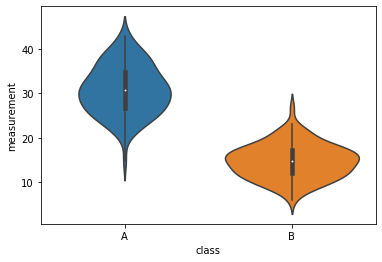

In [4]:
sns.violinplot(x="class", y="measurement", data=df);

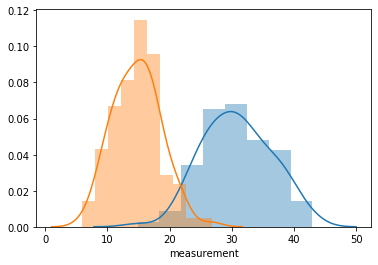

In [5]:
sns.distplot(df[df["class"] == "A"]["measurement"])
sns.distplot(df[df["class"] == "B"]["measurement"]);

In [6]:
# convert categorical values to numbers
df["class_num"] = df['class'].apply(lambda x: 1 if x == 'A' else 0 )
df.head()

,measurement,class,class_num
0,32.887273,A,1
1,11.350023,B,0
2,30.361653,A,1
3,15.287006,B,0
4,33.240028,A,1


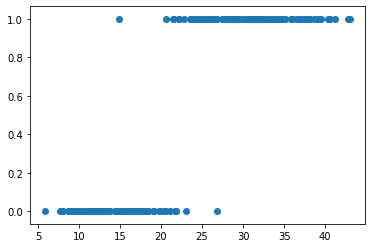

In [7]:
plt.scatter(df["measurement"], df["class_num"])
plt.show()

We could try to use a linear regression to separate the classes. With the best fit line we could label points above and below the line in seperate classes. This works ok (better than no classifier) but has a lot of drawbacks, and logistic regression typically gives a better solution. 

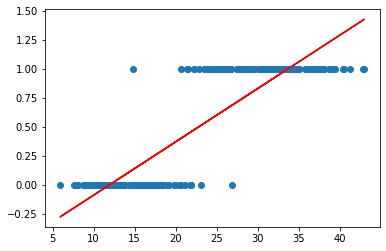

In [8]:
from sklearn import linear_model
X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict(X), color="r")
plt.show()

A logistic regression produces a classifier that separates the two classes much more sharply.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


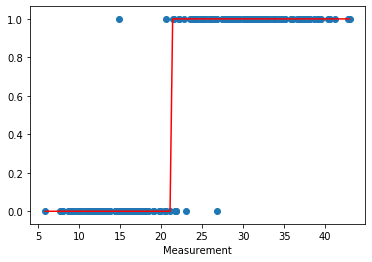

In [9]:
from sklearn import linear_model

df.sort_values(by="measurement", inplace=True)

X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict(X), color="r")
plt.xlabel("Measurement")
plt.show();

We can also plot the predicted probabilities and check the accuracy of the model.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


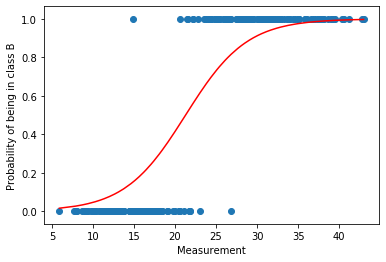

Accuracy 0.965


In [10]:
from sklearn import linear_model

df.sort_values(by="measurement", inplace=True)

X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict_proba(X)[:, 1], color="r")
plt.xlabel("Measurement")
plt.ylabel("Probability of being in class B")
plt.show()

print("Accuracy", model.score(X, y))

Now let's try a set of data that is not so well separated.

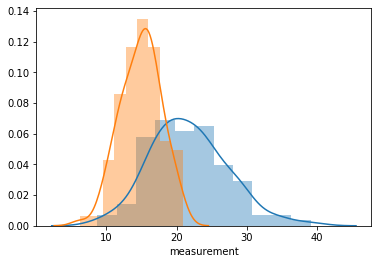

In [11]:
distA = stats.norm(22, 5)
distB = stats.norm(15, 3)

data = []
for i in range(100):
    data.append((distA.rvs(), "A"))
    data.append((distB.rvs(), "B"))
    
df = pd.DataFrame(data, columns=["measurement", "class"])
df["class_num"] = df['class'].apply(lambda x: 1 if x == 'A' else 0 )

sns.distplot(df[df["class"] == "A"]["measurement"])
sns.distplot(df[df["class"] == "B"]["measurement"]);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


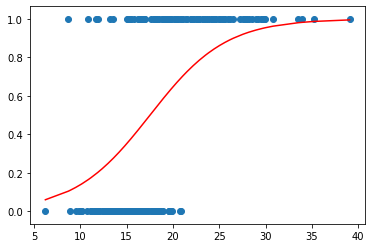

Accuracy 0.8


In [12]:
from sklearn import linear_model

df.sort_values(by="measurement", inplace=True)

X = df[["measurement"]]
y = df["class_num"]
model = linear_model.LogisticRegression()
model.fit(X, y)

plt.scatter(df["measurement"], df["class_num"])
plt.plot(df["measurement"], model.predict_proba(X)[:, 1], color="r")
plt.show()

print("Accuracy", model.score(X, y))